## Homework 3: Offline Policy Value Estimation (i.e. Counterfactual evaluation)

### Introduction
In this lab, we're going to be reproducing a few results from http://proceedings.mlr.press/v97/vlassis19a.html, and extending their results in a few ways.  Here's an overview: We start by taking a multiclass classification problem and splitting it into train and test.  There are 26 classes, which we'll interpret as 26 possible actions to take for every input context. On the training set, we fit a multinomial logistic regression model to predict the correct label/best action.  Following the paper, we create a logging policy based on this model (details supplied in the relevant spot below).  We then generate "logged bandit feedback" for this logging policy using the **test** set.  Given this logged bandit feedback, we'll try out several different methods for estimating the value of various policies.  We'll also estimate the value of each of these policies using the full-feedback (i.e. the full observed rewards), and we'll treat that as the ground truth value for the purpose of performance assessment.

### Load and process data

In [1]:
%load_ext autoreload
%autoreload 2

In [35]:
import abc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeCV, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd
from pandas.api.types import is_integer_dtype
import numpy as np
from numpy.random import default_rng
from scipy.special import expit
import seaborn as sns
import warnings;
warnings.filterwarnings('ignore');
import sys

In [3]:
def get_fully_observed_bandit():
    """
    This loads in a multiclass classification problem and reformulates it as a fully observed bandit problem.
    
    """
    df_l = pd.read_csv('data/letter-recognition.data',
                       names = ['a']+[f'x{i}' for i in range(16)])
    X = df_l.drop(columns=['a'])

    # Convert labels to ints and one-hot
    y = df_l['a']
    # if y is not column of integers (that represent classes), then convert
    if not is_integer_dtype(y.dtype):
        y = y.astype('category').cat.codes

    ## Full rewards
    n = len(y)
    k = max(y)+1
    full_rewards = np.zeros([n, k])
    full_rewards[np.arange(0,n),y] = 1
    contexts = X
    best_actions = y
    return contexts, full_rewards, best_actions

In [4]:
contexts, full_rewards, best_actions = get_fully_observed_bandit()
n, k = full_rewards.shape
_, d = contexts.shape
print(f"There are {k} actions, the context space is {d} dimensional, and there are {n} examples.")
print(f"For example, the first item has context vector:\n{contexts.iloc[0:1]}.")
print(f"The best action is {best_actions[0]}.  The reward for that action is 1 and all other actions get reward 0.")
print(f"The reward information is store in full_rewards as the row\n{full_rewards[0]}.")

There are 26 actions, the context space is 16 dimensional, and there are 20000 examples.
For example, the first item has context vector:
   x0  x1  x2  x3  x4  x5  x6  x7  x8  x9  x10  x11  x12  x13  x14  x15
0   2   8   3   5   1   8  13   0   6   6   10    8    0    8    0    8.
The best action is 19.  The reward for that action is 1 and all other actions get reward 0.
The reward information is store in full_rewards as the row
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0.].


In [5]:
## Choose train/test indices
rng = default_rng(7)
train_frac = 0.5
train_size = round(train_frac * n)
train_idx = rng.choice(n, size = train_size, replace = False)
test_idx = np.setdiff1d(np.arange(n), train_idx, assume_unique=True)

### Policies
In this section, we'll build out a Policy class, some specific policies, and evaluate policies on full-feedback data.

**Problem 1.** Complete the Policy class and the UniformActionPolicy classes below. Run the code provided to get an estimate of the value of the uniform action policy using the test set.  Explain why the value you get makes sense.

In [6]:
class Policy:
    def __init__(self, num_actions=2):
        self.num_actions = num_actions

    @abc.abstractmethod
    def get_action_distribution(self, X):
        """   
        This method is intended to be overridden by each implementation of Policy.

        Args:
            X (pd.DataFrame): contexts

        Returns:
            2-dim numpy array with the same number of rows as X and self.num_actions columns. 
                Each rows gives the policy's probability distribution over actions conditioned on the context in the corresponding row of X
        """   
        raise NotImplementedError("Must override method")

    def get_action_propensities(self, X, actions):
        """   
        Args:
            X (pd.DataFrame): contexts, rows correspond to entries of actions
            actions (np.array): actions taken, represented by integers, corresponding to rows of X

        Returns:
            1-dim numpy array of probabilities (same size as actions) for taking each action in its corresponding context
        """   
        ## DONE
        action_distribution = self.get_action_distribution(X)
        return np.take_along_axis(action_distribution, actions.reshape(-1, 1), axis=1).flatten()

    def select_actions(self, X, rng=default_rng(1)):
        """   
        Args:
            X (pd.DataFrame): contexts, rows correspond to entries of actions and propensities returned

        Returns:
            actions (np.array): 1-dim numpy array of length equal to the number of rows of X.  Each entry is an integer indicating the action selected for the corresponding context in X. 
                The action is selected randomly according to the policy, conditional on the context specified in the appropriate row of X.
            propensities (np.array): 1-dim numpy array of length equal to the number of rows of X; gives the propensity for each action selected in actions

        """   
        ## DONE
        action_distribution = self.get_action_distribution(X)
        actions = np.array([np.random.choice(26, 1, p=action_distribution[i]) for i in range(X.shape[0])]).flatten()
        propensities = self.get_action_propensities(X, actions)
        assert len(actions) == len(propensities) == X.shape[0]
        
        return actions, propensities
        
        
    def get_value_estimate(self, X, full_rewards):
        """   
        Args:
            X (pd.DataFrame): contexts, rows correspond to entries of full_rewards
            full_rewards (np.array): 2-dim numpy array with the same number of rows as X and self.num_actions columns; 
                each row gives the rewards that would be received for each action for the context in the corresponding row of X.
                This would only be known in a full-feedback bandit, or estimated in a direct method

        Returns:
            scalar value giving the expected average reward received for playing the policy for contexts X and the given full_rewards

        """   
        ## DONE
        n = X.shape[0]
        actions, propensities = self.select_actions(X)
        action_distribution = self.get_action_distribution(X)
        
        return (full_rewards*action_distribution).sum()/n


class UniformActionPolicy(Policy):
    def __init__(self, num_actions=2):
        self.num_actions = num_actions

    def get_action_distribution(self, X):
        ## DONE
        return np.full((X.shape[0], self.num_actions), 1.0/self.num_actions)

In [7]:
X_train = contexts.iloc[train_idx].to_numpy()
y_train = best_actions.iloc[train_idx].to_numpy()
X_test = contexts.iloc[test_idx].to_numpy()
y_test = best_actions.iloc[test_idx].to_numpy()
full_rewards_test = full_rewards[test_idx]

uniform_policy = UniformActionPolicy(num_actions=k)
uniform_policy_value = uniform_policy.get_value_estimate(X=X_test, full_rewards=full_rewards_test)
print(f"The estimate of the value of the uniform action policy using the full-feedback test set is {uniform_policy_value}.")

The estimate of the value of the uniform action policy using the full-feedback test set is 0.038461538461538484.


This estimate of the value of this uniform action policy is $\frac{1}{26}$. This makes sense because as the formulation of the value estimate suggests, $$V(\pi) = \frac{1}{n}\sum_{i=1}^{n}\sum_{a=1}^{k}[r(X_i, a)\pi(a|X_i)],$$ in the inner sum every propensity score is $\frac{1}{26}$ and only $1$ action out of $26$ has the reward $1$ while the rest is $0$. Thus, the inner sum is essentially $\frac{1}{26}$. We add $\frac{1}{26}$ up for $n$ times and take the average, which results in $\frac{1}{26}$ as value.

**Problem 2.**  Complete the SKLearnPolicy class below and run the code that creates two policies and estimates their values using the full reward information in the test set.  You should find that the deterministic policy has a higher value than the stochastic policy.  Nevertheless, why might one choose to deploy the stochastic policy rather than the deterministic policy?

In [8]:
## Develop more policies

class SKLearnPolicy(Policy):
    """ 
    An SKLearnPolicy uses a scikit learn model to generate an action distribution.  If the SKLearnPolicy is built with is_deterministic=False, 
    then the predict distribution for a context x should be whatever predict_proba for the model returns.  If is_deterministic=True, then all the probability mass 
    should be concentrated on whatever predict of the model returns.
    """
    def __init__(self, model, num_actions=2, is_deterministic=False):
        self.is_deterministic = is_deterministic
        self.num_actions = num_actions
        self.model = model

    def get_action_distribution(self, X):
        ## DONE
        if (self.is_deterministic):
            predictions = self.model.predict(X)
            return np.eye(self.num_actions)[predictions.reshape(-1)] # one hot
        else:
            return self.model.predict_proba(X)


    def select_actions(self, X, rng=default_rng(1)):
        ## DONE
        if (self.is_deterministic):
            actions = self.model.predict(X)
            propensities = np.full(len(actions), 1.0)
            return actions, propensities
        else:
            actions, propensities = Policy.select_actions(self, X)
            return actions, propensities

model = LogisticRegression(multi_class='multinomial')
model.fit(X_train, y_train)
policy_stochastic = SKLearnPolicy(model=model, num_actions=k, is_deterministic=False)
policy_deterministic = SKLearnPolicy(model=model, num_actions=k, is_deterministic=True)

policy_stochastic_true_value = policy_stochastic.get_value_estimate(X_test, full_rewards_test)
policy_deterministic_true_value = policy_deterministic.get_value_estimate(X_test, full_rewards_test)
print(f"Stochastic policy true value {policy_stochastic_true_value}.")
print(f"Deterministic policy true value {policy_deterministic_true_value}.")

Stochastic policy true value 0.6261601174415055.
Deterministic policy true value 0.7631.


Since we know our training data is biased towards $\pi_0$, the deterministic policy may also be biased and offeres no exploration. On the other hand the stochastic policy offers exploration by randomly selecting actions based on the action distribution trained from data. 

**Problem 3.** Fill in the VlassisLoggingPolicy class below, and evaluate the value of this logging policy using the code provided.

In [9]:
class VlassisLoggingPolicy(Policy):
    """
    This policy derives from another deterministic policy following the recipe described in the Vlassis et al paper, on the top of the second column in section 5.3.
    For any context x, if the deterministic policy selects action a, then this policy selects action a with probability eps (a supplied parameter), and spreads the
    rest of the probability mass uniformly over the other actions.
    """
    def __init__(self, deterministic_target_policy, num_actions=2, eps=0.05):
        self.num_actions = num_actions
        self.target_policy = deterministic_target_policy
        self.eps = eps

    def get_action_distribution(self, X):
        rest = (1.0-self.eps)/(self.num_actions-1)
        actions, propensities = self.target_policy.select_actions(X)
        action_distribution = np.eye(self.num_actions)[actions.reshape(-1)]*self.eps
        action_distribution[action_distribution == 0.0] = rest
        return action_distribution
        
    
logging_policy = VlassisLoggingPolicy(policy_deterministic, num_actions=k, eps=0.05)
logging_policy_value = logging_policy.get_value_estimate(X=X_test, full_rewards=full_rewards_test)
print(f"The estimate of the value of the logging policy using the full-feedback test set is {logging_policy_value}.")

The estimate of the value of the logging policy using the full-feedback test set is 0.04715720000000002.


### Simulate bandit feedback and on-policy evaluation
**Problem 4.** Take a look at the generate_bandit_feedback function, so you understand how it works.  Then generate bandit feedback using the test data -- generate as many rounds are there are contexts in the test data. Use the result to generate an "on-policy" estimate of the value of the logging policy.  How does it compare to our "ground truth" estimate you found previously using the full-feedback test set? Repeat using 1/100th, 1/10th, and 10x as much bandit feedback, to see how much the value estimates change.

In [10]:
def generate_bandit_feedback(contexts, full_rewards, policy,
                             new_n = None,
                             rng=default_rng(1)):
    """   
    Args:
        contexts (np.array): contexts, rows correspond to entries of rewards
        full_rewards (np.array): 2-dim numpy array with the same number of rows as X and number of columns corresponding to the number actions
            each row gives the reward that would be received for each action for the context in the corresponding row of X. 

    Returns:
        new_contexts (np.array): new_n rows and same number of columns as in contexts
        actions (np.array): vector with new_n entries giving actions selected by the provided policy for the contexts in new_contexts
        observed_rewards (np.array): vector with new_n entries giving actions selected by the provided policy for the contexts in new_contexts 
    """   
    
    if new_n is None:
        new_n = contexts.shape[0]
    n, k = full_rewards.shape
    num_repeats = np.ceil(new_n / n).astype(int)
    new_contexts = np.tile(contexts, [num_repeats,1])
    new_contexts = new_contexts[0:new_n]
    new_rewards = np.tile(full_rewards, [num_repeats,1])
    new_rewards = new_rewards[0:new_n]
    actions, propensities = policy.select_actions(X=new_contexts, rng=rng)
    observed_rewards = new_rewards[np.arange(new_n), actions]
    return new_contexts, actions, observed_rewards, propensities

In [11]:
n = full_rewards_test.shape[0]
vals = []

for n_ in [n/100, n/10, n, 10*n]:
    new_contexts, actions, observed_rewards, propensities = generate_bandit_feedback(X_test, full_rewards_test,\
                                                                logging_policy, new_n=int(n_), rng=default_rng(1))
    vals.append(sum(observed_rewards*propensities)/n)
    

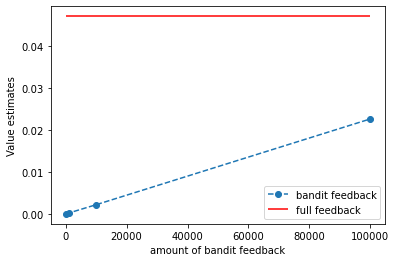

In [12]:
import matplotlib.pyplot as plt

plt.plot([n/100, n/10, n, 10*n], vals, "--o", label="bandit feedback")
plt.xlabel("amount of bandit feedback")
plt.ylabel("Value estimates")
plt.hlines(logging_policy_value, xmin=0, xmax=100000, label="full feedback", color="r")
plt.legend(loc=4)

As we can see, with more bandit feedback, the higher the value estimate will be.

### Test out off-policy value estimators
**Problem 5.** Complete the get_value_estimators function below, per the specification.  Include the following estimators
- Unweighted mean (done for you)
- Importance-weighted (IW) value estimator
- Self-normalized IW mean
- Direct method with linear ridge regression reward predictor fit for each action
- Direct method with IW-linear ridge regression reward predictor fit for each action
- [Optional (not for credit)] Direct method with a non-linear reward predictor fit for each action
- [Optional (not for credit)] Direct method with a non-linear reward predictor fit for all actions at once (action becomes part of the input)

Run the code below that will apply your value estimators to a policy on logged bandit feedback. Verify that your results are reasonable. (Don't worry if your numbers are not a very close match for the results in the table.)

In [100]:
## Build our value estimators

def get_value_estimators(policy, contexts, actions, rewards, propensities, skip_slow_stuff=False):
    """   
    Args:
        policy (Policy): the policy we want to get a value estimate for
        contexts (np.array): contexts from bandit feedback
        actions (np.array): actions chosen for bandit feedback
        rewards (np.array): rewards received in bandit feedback
        propensities (np.array): the propensity for each action selected under the logging policy (which is not provided to this function)
        skip_slow_stuff (boolean): boolean flag which allows you to turn on/off some slow estimators (ignore this if you like)
    Returns:
        est (dict): keys are string describing the value estimator, values are the corresponding value estimates 
    """   

    est = {}
    est["mean"] = np.mean(rewards)
    
    ## DONE
    pi_w = policy.get_action_propensities(contexts, actions)
    
    assert len(rewards) == len(pi_w) == len(propensities)
    importance_weights = pi_w/propensities
    
    est["IW"] = np.mean(rewards*importance_weights)
    est["SNIW"] = np.sum(rewards*importance_weights) / np.sum(importance_weights)
    
    if not skip_slow_stuff:
        models = []
        for i in range(26):
            idx = actions == i
            X = contexts[idx]
            y = rewards[idx]
            model = Ridge()
            model.fit(X, y)
            models.append(model)
            
        n = len(actions)
        res = 0.0
        for i in range(n):
            X_i = contexts[i].reshape(1, -1)
            all_action_propensities = policy.get_action_propensities(X_i, np.arange(26))
            predicted_rewards = []
            for a in range(26):
                model = models[a]
                predicted_reward = model.predict(X_i)[0]
                predicted_rewards.append(predicted_reward)
            res += sum(all_action_propensities * np.asarray(predicted_rewards))
        est["Ridge"] = res/n
        
        
        models = []
        for i in range(26):
            idx = actions == i
            X = contexts[idx]
            y = rewards[idx]
            p_0 = propensities[idx]
            p_w = policy.get_action_propensities(X, np.full(X.shape[0], i, dtype=int))
            sample_weights = p_w/p_0
            model = Ridge()
            model.fit(X, y, sample_weights)
            models.append(model)
            
        n = len(actions)
        res = 0.0
        for i in range(n):
            X_i = contexts[i].reshape(1, -1)
            propensities = policy.get_action_propensities(X_i, np.arange(26))
            predicted_rewards = []
            for a in range(26):
                model = models[a]
                predicted_reward = model.predict(X_i)[0]
                predicted_rewards.append(predicted_reward)
            res += sum(propensities*np.asarray(predicted_rewards))
        est["Ridge_IW"] = res/n
        
    return est


In [101]:
def get_estimator_stats(estimates, true_parameter_value=None):
    """
 
     Args:
        estimates (pd.DataFrame): each row corresponds to collection of estimates for a sample and
            each column corresponds to an estimator
        true_parameter_value (float): the true parameter value that we will be comparing estimates to
            
    Returns:
        pd.Dataframe where each row represents data about a single estimator
    """
    
    est_stat = []
    for est in estimates.columns:
        pred_means = estimates[est]
        stat = {}
        stat['stat'] = est
        stat['mean'] = np.mean(pred_means)
        stat['SD'] = np.std(pred_means)
        stat['SE'] = np.std(pred_means) / np.sqrt(len(pred_means))
        if true_parameter_value:
            stat['bias'] = stat['mean'] - true_parameter_value
            stat['RMSE'] = np.sqrt(np.mean((pred_means - true_parameter_value) ** 2))
        est_stat.append(stat)

    return pd.DataFrame(est_stat)

In [102]:
contexts_test, actions_test, rewards_test, propensities_test = generate_bandit_feedback(contexts=X_test, full_rewards=full_rewards_test, policy=logging_policy, rng=default_rng(6))
policy = policy_deterministic
est = get_value_estimators(policy, contexts_test, actions_test, rewards_test, propensities_test)
policy_true_value = policy.get_value_estimate(X_test, full_rewards_test)
print(f"policy true value {policy_true_value}.")
df = pd.DataFrame(est, index=[0])
est

policy true value 0.7631.


{'mean': 0.0482,
 'IW': 0.816,
 'SNIW': 0.783109404990403,
 'Ridge': 0.27112898219944515,
 'Ridge_IW': 0.7623822729000462}

**Problem 6.** Run the code below to test your value estimators across multiple trials.  Write a few sentences about anything you learned from these experiments or that you find interesting.

In [103]:
trials=20
val_ests = []
policy = policy_deterministic
policy_true_value = policy.get_value_estimate(X_test, full_rewards_test)
rng=default_rng(6)
for i in range(trials):
    contexts, actions, rewards, propensities = generate_bandit_feedback(X_test, full_rewards_test, logging_policy, rng=rng)
    est = get_value_estimators(policy, contexts, actions, rewards, propensities)
    val_ests.append(est)

df = pd.DataFrame(val_ests)
print(get_estimator_stats(df, true_parameter_value=policy_true_value))

       stat      mean        SD        SE      bias      RMSE
0      mean  0.046790  0.002009  0.000449 -0.716310  0.716313
1        IW  0.762100  0.030799  0.006887 -0.001000  0.030815
2      SNIW  0.762522  0.012827  0.002868 -0.000578  0.012841
3     Ridge  0.266487  0.009019  0.002017 -0.496613  0.496695
4  Ridge_IW  0.791159  0.031913  0.007136  0.028059  0.042494


In [104]:
trials=20
val_ests = []
policy = policy_stochastic
policy_true_value = policy.get_value_estimate(X_test, full_rewards_test)
rng=default_rng(6)
for i in range(trials):
    contexts, actions, rewards, propensities = generate_bandit_feedback(X_test, full_rewards_test, logging_policy, rng=rng)
    est = get_value_estimators(policy, contexts, actions, rewards, propensities)
    val_ests.append(est)

df = pd.DataFrame(val_ests)
print(get_estimator_stats(df, true_parameter_value=policy_true_value))

       stat      mean        SD        SE      bias      RMSE
0      mean  0.047580  0.001715  0.000384 -0.578580  0.578583
1        IW  0.634605  0.022671  0.005069  0.008445  0.024192
2      SNIW  0.628373  0.012770  0.002856  0.002213  0.012961
3     Ridge  0.254693  0.007423  0.001660 -0.371467  0.371541
4  Ridge_IW  0.610243  0.016766  0.003749 -0.015918  0.023118


In [105]:
trials=20
val_ests = []
policy = uniform_policy
policy_true_value = policy.get_value_estimate(X_test, full_rewards_test)
rng=default_rng(6)
for i in range(trials):
    contexts, actions, rewards, propensities = generate_bandit_feedback(X_test, full_rewards_test, logging_policy, rng=rng)
    est = get_value_estimators(policy, contexts, actions, rewards, propensities)
    val_ests.append(est)

df = pd.DataFrame(val_ests)
print(get_estimator_stats(df, true_parameter_value=policy_true_value))

       stat      mean        SD        SE      bias      RMSE
0      mean  0.047705  0.002322  0.000519  0.009243  0.009531
1        IW  0.038915  0.001803  0.000403  0.000454  0.001859
2      SNIW  0.038921  0.001826  0.000408  0.000460  0.001883
3     Ridge  0.044560  0.001578  0.000353  0.006099  0.006299
4  Ridge_IW  0.038709  0.001403  0.000314  0.000247  0.001425


As we can see across the 3 policies, uniform policy has a very low value. Stochastic and deterministic policies are more preferable. Also, importance weighting is very important due to the selection bias; this is true in both reward imputation and importance weighting. Of course, they are all better than the naive unweighted mean estimate. Also, using self-normalized weights on top of importance weighting gives the best result generally.